
# Modelos de Linguagem — **Parte 3**  
## Máscaras, Tipos de Atenção e Positional Encoding



In [ ]:
# Se necessário:
# !pip install transformers torch --quiet

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Para PT-2 pt-BR, ex.: "pierreguillou/gpt2-small-portuguese"
# Se houver dificuldade de download, use "gpt2"
GPT2_NAME = "gpt2"

gpt2_tokenizer = AutoTokenizer.from_pretrained(GPT2_NAME)
gpt2_model = AutoModelForCausalLM.from_pretrained(GPT2_NAME, output_attentions=True).to(DEVICE)
gpt2_model.eval()

sentence_gpt = "The cat sat on the mat."
enc_gpt = gpt2_tokenizer(sentence_gpt, return_tensors="pt", add_special_tokens=True)
input_ids_gpt = enc_gpt["input_ids"].to(DEVICE)

with torch.no_grad():
    out_gpt = gpt2_model(input_ids=input_ids_gpt)

att_gpt = out_gpt.attentions  # tupla por camada, cada: (1, heads, T, T)
tokens_gpt = gpt2_tokenizer.convert_ids_to_tokens(input_ids_gpt[0])
print("Tokens GPT-2:", tokens_gpt)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Tokens GPT-2: ['The', 'Ġcat', 'Ġsat', 'Ġon', 'Ġthe', 'Ġmat', '.']


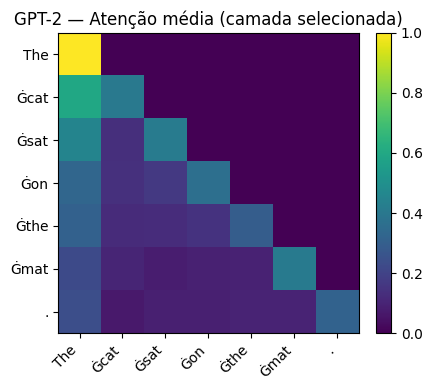

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_mean_causal(attentions, tokens, layer_idx=-1, figsize=(5,4)):
    att = attentions[layer_idx].mean(dim=1)[0].cpu().numpy()  # (T, T)
    plt.figure(figsize=figsize)
    im = plt.imshow(att)
    plt.title("GPT-2 — Atenção média (camada selecionada)")
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
    plt.yticks(range(len(tokens)), tokens)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

plot_attention_mean_causal(att_gpt, tokens_gpt, layer_idx=len(att_gpt)-24)

### Como interpretar os mapas

- **Cada quadrado é uma cabeça de atenção**.
- **Linhas** = token "consultando" (Query).  
- **Colunas** = token "consultado" (Key).
- Tons mais fortes = maior peso de atenção.

## Resumo até aqui...

<br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/attention_matrix.png" width="60%%">

Fonte: https://github.com/rasbt/LLMs-from-scratch/

<br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/attention_summary.png" width="60%%">

Fonte: https://github.com/rasbt/LLMs-from-scratch/

## O que fazemos com a saída do mecanismo de atenção?

Até agora vimos como calcular os pesos de atenção e usá-los para combinar os vetores de valor (V).  
O resultado final é, para cada token, um **vetor contextualizado** — ele não representa só o token em si, mas também o que esse token "aprendeu" ao olhar para os outros.

Este vetor serve para, por exemplo:

- **Enriquecer representações:** a saída do mecanismo de atenção é uma forma de dizer:  
  > "Este token não está sozinho, ele existe em um contexto."  
- **Capturar dependências:** em vez de ter apenas um embedding fixo da palavra, agora temos um embedding que **reflete relações** (quem depende de quem, quem modifica quem, etc.).  
- **Preparar para etapas seguintes:** esse vetor pode ser:
  - Entrada para outra camada de atenção (empilhar atenção sobre atenção).  
  - Entrada para uma rede densa (*feed-forward*) que gera novas representações.  
  - Ou usado diretamente em uma tarefa (ex.: classificar uma sentença, escolher a próxima palavra, comparar pares de frases).

Isso funciona como **matéria-prima processada** — já trazida para um espaço mais rico, pronta para ser refinada.



## Máscaras: **padding** e **causal** (por que e como usar)

O mecanismo de atenção permite que cada posição da sequência olhe para todas as outras.  
Mas nem sempre isso é desejável → precisamos de **máscaras** para controlar **quem pode olhar para quem**.

Existem dois tipos principais de máscaras no Transformer:

---

### Padding Mask
- **Problema:**  
  Em batch, frases têm comprimentos diferentes. Para igualar, usamos tokens de *padding* (`[PAD]`).
- **Sem máscara:**  
  Esses tokens "vazios" participariam da atenção, contaminando os pesos.
- **Com máscara:**  
  Marcamos as posições de padding com `-∞` (ou um número muito negativo) **antes do softmax**.  
  Assim, suas contribuições ficam **zeradas**.
- **Quando usar:**  
  Sempre que tivermos **batches com padding** (tanto em encoder quanto em decoder).
- **Exemplo:**  
  Batch = ["O gato dormiu", "O cachorro"]  
  → a segunda frase terá padding; sem máscara, o modelo poderia dar atenção a algo que "não existe".

---

### Causal Mask (ou Look-Ahead Mask)
- **Problema:**  
  Em modelos geradores (decoder), cada posição não pode olhar para o futuro.  
  Ex.: ao prever a 3ª palavra, não pode usar a 4ª que ainda não foi gerada.
- **Sem máscara:**  
  O modelo veria o futuro → vazamento de informação → aprendizado incorreto.
- **Com máscara:**  
  Bloqueamos todas as posições **acima da diagonal** da matriz de atenção.  
  Resultado: cada posição só pode consultar a si mesma e as anteriores.
- **Quando usar:**  
  Em **decoders autoregressivos** (tradução, geração de texto, LLMs como GPT).
- **Exemplo:**  
  Para a frase "O gato sentou":  
  - "O" → olha só para "O".  
  - "gato" → olha para ["O", "gato"].  
  - "sentou" → olha para ["O", "gato", "sentou"].  

---

### Máscara combinada (Padding + Causal)
- Em modelos decoder-only (ex.: GPT), usamos **padding mask + causal mask ao mesmo tempo**.  
  Assim:  
  - Garantimos que o modelo não olhe para tokens futuros.  
  - Garantimos que ele ignore tokens de padding.  

---

### Implementação prática
- O truque não é **zerar depois do softmax**, e sim adicionar valores `-∞` **antes**.  
- Por quê?  
  - O softmax normalizaria os pesos e ainda poderia dar probabilidade a posições inválidas.  
  - Com `-∞`, o softmax produz exatamente 0 nessas posições.  


Padding mask shape: (2, 1, 5)
Padding mask para cada exemplo (1=mask/padding, 0=válido):

[[0 0 0 1 1]
 [0 0 0 0 0]]

Causal mask (T=6) – 1 indica posições FUTURAS mascaradas:

[[0 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]


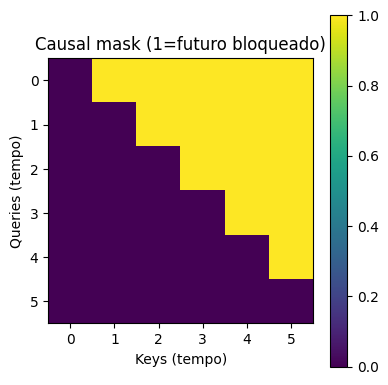

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def make_padding_mask(lengths, max_len=None):
    """Retorna máscara booleana no formato (B, 1, T): True onde é padding (deve mascarar)."""
    if max_len is None:
        max_len = int(max(lengths))
    idxs = np.arange(max_len)[None, :]            # (1, T)
    base = np.array(lengths)[:, None]             # (B, 1)
    mask = idxs >= base                           # (B, T) -> True nas posições de padding
    return mask[:, None, :]                       # (B, 1, T)

def make_causal_mask(T):
    """Máscara causal (1, T, T): True acima da diagonal (futuro, deve mascarar)."""
    return np.triu(np.ones((T, T), dtype=bool), k=1)[None, :, :]

# Demonstração padding: duas frases com comprimentos diferentes
lengths = [3, 5]
pad_mask = make_padding_mask(lengths, max_len=5)  # esperado: (B=2, 1, T=5)

print("Padding mask shape:", pad_mask.shape)
print("Padding mask para cada exemplo (1=mask/padding, 0=válido):\n")
print(pad_mask.astype(int)[:, 0, :])

# Visual da máscara causal
T = 6
causal = make_causal_mask(T)[0].astype(int)
print("\nCausal mask (T=6) – 1 indica posições FUTURAS mascaradas:\n")
print(causal)

# Plot simples da máscara causal
plt.figure(figsize=(4,4))
plt.imshow(causal)
plt.title("Causal mask (1=futuro bloqueado)")
plt.xlabel("Keys (tempo)")
plt.ylabel("Queries (tempo)")
plt.colorbar()
plt.tight_layout()
plt.show()


### Aplicando as máscaras na atenção (efeito prático)

Vamos verificar que:
- Com **padding mask**, os pesos em posições de padding ficam ~0 e **não influenciam**.  
- Com **causal mask**, cada posição só pode olhar para si e para o **passado**.


In [ ]:

import numpy as np

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.shape[-1]
    scores = Q @ K.transpose(0, 2, 1) / np.sqrt(d_k)
    if mask is not None:
        scores = np.where(mask, -1e9, scores)
    weights = softmax(scores, axis=-1)
    return weights @ V, weights

# Exemplo com padding: batch com 2 frases, comprimentos diferentes
np.random.seed(1)
B, T, d = 2, 5, 8
lengths = [3, 5]
X = np.random.randn(B, T, d)
Wq = np.random.randn(d, d); Wk = np.random.randn(d, d); Wv = np.random.randn(d, d)
Q, K, V = X @ Wq, X @ Wk, X @ Wv

# Cria padding mask (B,1,T) e expande para (B,Tq,Tk)
pad_mask = (np.repeat((np.arange(T)[None,:] >= np.array(lengths)[:,None])[:,None,:], repeats=T, axis=1))  # (B,T,T)

# Atenção com padding mask
out_pad, att_pad = scaled_dot_product_attention(Q, K, V, mask=pad_mask)

print("Soma das linhas dos pesos (deveria ser 1 mesmo com máscara):")
print(np.round(att_pad.sum(axis=-1), 3))  # (B,T)

# Causal mask para um único exemplo (didático)
T = 5
X = np.random.randn(1, T, d)
Q, K, V = X @ Wq, X @ Wk, X @ Wv
causal = np.triu(np.ones((1, T, T), dtype=bool), k=1)  # (1,T,T)

out_causal, att_causal = scaled_dot_product_attention(Q, K, V, mask=causal)
print("\nAtenção causal — matriz (T x T):\n", np.round(att_causal[0], 2))


Soma das linhas dos pesos (deveria ser 1 mesmo com máscara):
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]

Atenção causal — matriz (T x T):
 [[1.   0.   0.   0.   0.  ]
 [0.33 0.67 0.   0.   0.  ]
 [0.19 0.44 0.37 0.   0.  ]
 [0.   0.84 0.16 0.   0.  ]
 [0.   0.   0.   0.   1.  ]]


<br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/masked_attention.png" width="60%%">

Fonte: https://github.com/rasbt/LLMs-from-scratch/

## Por que não simplesmente "zerar" no Masked Attention?

À primeira vista, parece que poderíamos resolver o problema da máscara **zerando os pesos** onde não se deve olhar (por exemplo, posições futuras no decoder).

Mas isso **não funciona bem** porque:

1. **Softmax exige diferenças relativas**  
   A atenção é calculada com:
   $$
   \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}} + \text{mask}\right)
   $$
   Se simplesmente colocamos `0`, o `softmax` ainda pode atribuir **probabilidade não-nula** para aquela posição, já que `0` pode ser maior que outros valores negativos.

2. **Precisamos de “-∞” (ou um número muito negativo)**  
   Ao adicionar `-∞` nas posições mascaradas, garantimos que o `softmax` zere exatamente aquelas probabilidades, pois:
   $$
   e^{-\infty} = 0
   $$

3. **Robustez numérica**  
   Implementações usam um valor muito negativo (ex.: `-1e9`) em vez de `-∞`, por questões de estabilidade computacional.  
   Isso é suficiente para que o `softmax` trate essas entradas como **zero absoluto**.

Em resumo:  
- **Não basta zerar depois**, porque o `softmax` redistribuiria as probabilidades.  
- Precisamos aplicar a máscara **antes** do `softmax`, adicionando valores muito negativos nas posições proibidas.

## Tipos de Atenção: quando e por que usar cada uma

O mecanismo de atenção pode assumir diferentes papéis dentro do Transformer.  
Vamos detalhar os principais tipos:

---

### Self-Attention (Encoder)
- **Como funciona:**  
  Q, K e V vêm da **mesma sequência de entrada**.  
- **Quando usar:**  
  No encoder, para processar a frase de entrada inteira ao mesmo tempo.  
- **Por que usar:**  
  - Captura relações entre **todas as palavras da entrada**, independentemente da distância.  
  - Exemplo: em "O gato que estava cansado sentou", a atenção ajuda a conectar "gato" com "sentou", mesmo com várias palavras no meio.  

---

### Masked Self-Attention (Decoder)
- **Como funciona:**  
  Q, K e V vêm da **mesma sequência de saída**, mas com **máscara causal** → cada posição só pode olhar para si e para o passado.  
- **Quando usar:**  
  No decoder de modelos geradores (ex.: tradução, GPT-2, LLMs em geral).  
- **Por que usar:**  
  - Garante a propriedade **autoregressiva**: o modelo não pode "espiar" o futuro.  
  - Exemplo: ao gerar "O gato ...", na posição do segundo token "gato", o modelo não pode usar "sentou" (que vem depois).  

---

### Encoder–Decoder Attention (Cross-Attention)
- **Como funciona:**  
  - Q vem do **decoder** (tokens já gerados ou mascarados).  
  - K e V vêm do **encoder** (representações da entrada).  
- **Quando usar:**  
  Em tarefas de **seq2seq** (tradução automática, resumo, legendagem).  
- **Por que usar:**  
  - Permite que o decoder "consulte" toda a informação processada pelo encoder.  
  - Exemplo: traduzir "The cat sat" → enquanto gera "O gato sentou", o decoder consulta as representações do inglês.  

---

### Multi-Head Attention
- **Como funciona:**  
  O modelo calcula **várias atenções em paralelo** (cabeças). Cada cabeça tem seus próprios pesos ($W_Q, W_K, W_V$).  
- **Quando usar:**  
  Sempre, em todas as camadas do Transformer.  
- **Por que usar:**  
  - Cada cabeça aprende **padrões diferentes** (curto alcance, longo alcance, sintaxe, semântica, etc.).  
  - O conjunto delas gera uma representação mais rica.  
  - Exemplo: numa mesma frase, uma cabeça pode ligar sujeito ↔ verbo, outra substantivo ↔ adjetivo, outra palavra ↔ pontuação.  

---

### Cross-Attention
- **Como funciona:**  
  Uma sequência consulta outra que não precisa vir de um encoder/decoder específico.  
- **Quando usar:**  
  Em arquiteturas híbridas (ex.: multimodal — texto ↔ imagem, áudio ↔ texto).  
- **Por que usar:**  
  - Permite integrar diferentes fontes de informação.  
  - Exemplo: gerar legenda de uma imagem → o texto (decoder) consulta representações da imagem (encoder visual).  

---

**Resumo prático:**
- **Self-Attention:** entender a entrada como um todo.  
- **Masked Self-Attention:** gerar saídas passo a passo, sem olhar o futuro.  
- **Encoder–Decoder Attention:** conectar entrada ↔ saída em tarefas seq2seq.  
- **Multi-Head Attention:** enriquecer os padrões de dependência aprendidos.  
- **Cross-Attention:** integrar modalidades ou sequências diferentes.

In [ ]:

import numpy as np

def attn(Q, K, V, mask=None):
    d_k = Q.shape[-1]
    scores = Q @ K.transpose(0,2,1) / np.sqrt(d_k)
    if mask is not None:
        scores = np.where(mask, -1e9, scores)
    # softmax
    e = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    w = e / np.sum(e, axis=-1, keepdims=True)
    return w @ V, w

np.random.seed(11)
d = 8

# Encoder: self-attention na entrada
X_src = np.random.randn(1, 5, d)
Wq = np.random.randn(d, d); Wk = np.random.randn(d, d); Wv = np.random.randn(d, d)
Qe, Ke, Ve = X_src @ Wq, X_src @ Wk, X_src @ Wv
out_enc, w_enc = attn(Qe, Ke, Ve, mask=None)  # (self-attention sem máscara)

# Decoder: masked self-attention na saída parcial
Y_tgt = np.random.randn(1, 4, d)
Qd, Kd, Vd = Y_tgt @ Wq, Y_tgt @ Wk, Y_tgt @ Wv
causal = np.triu(np.ones((1, 4, 4), dtype=bool), k=1)
out_dec_self, w_dec_self = attn(Qd, Kd, Vd, mask=causal)

# Encoder–Decoder Attention: Q do decoder, K,V do encoder
out_encdec, w_encdec = attn(Qd, Ke, Ve, mask=None)

print("Self-Attention encoder (w_enc):\n", np.round(w_enc[0], 2))
print("\nMasked Self-Attention decoder (w_dec_self):\n", np.round(w_dec_self[0], 2))
print("\nEncoder–Decoder Attention (w_encdec):\n", np.round(w_encdec[0], 2))


Self-Attention encoder (w_enc):
 [[0.93 0.   0.07 0.   0.  ]
 [0.02 0.86 0.   0.09 0.04]
 [1.   0.   0.   0.   0.  ]
 [0.07 0.   0.75 0.   0.17]
 [0.   1.   0.   0.   0.  ]]

Masked Self-Attention decoder (w_dec_self):
 [[1.   0.   0.   0.  ]
 [0.61 0.39 0.   0.  ]
 [0.   0.05 0.95 0.  ]
 [0.   0.01 0.   0.99]]

Encoder–Decoder Attention (w_encdec):
 [[0.24 0.   0.76 0.   0.  ]
 [0.02 0.   0.96 0.   0.02]
 [0.   0.   0.24 0.09 0.66]
 [0.   0.56 0.   0.44 0.  ]]


## Positional Encoding: por que e como funciona

O **self-attention** não tem noção de ordem.  
Por isso, precisamos **adicionar informação posicional** para que a rede saiba distinguir, por exemplo, "o gato comeu o peixe" de "o peixe comeu o gato".

### O problema (a dor que ele resolve)
O mecanismo de **self-attention** enxerga apenas *um conjunto de vetores* (os embeddings das palavras).  
Ele sabe **quais palavras existem**, mas **não sabe em que ordem** aparecem.

Sem posição, "O gato mordeu o cachorro" seria indistinguível de "O cachorro mordeu o gato".  
O Transformer precisa de alguma forma de **entender a ordem** para capturar o sentido correto.

---

### Quem usa?
Todos os modelos baseados em **Transformers** que dependem de self-attention:  
- **Encoders** (ex.: BERT) → precisam da ordem para analisar frases inteiras.  
- **Decoders** (ex.: GPT) → precisam da ordem para gerar tokens na sequência correta.  
- **Modelos seq2seq** (ex.: T5, MarianMT, BART) → tanto encoder quanto decoder usam posições.

---

### Para que serve?
- Dá ao modelo a noção de **posição absoluta** de cada token na frase.  
- Permite que ele reconheça **distâncias relativas** (quem está perto, quem está longe).  
- Ajuda a capturar **padrões de sequência**: sujeito–verbo, verbo–objeto, etc.  

Sem positional encoding, o Transformer se comportaria como um **saco de palavras** (*bag of words*): sabe as palavras, mas não sabe a estrutura.

---

### Como é usado?
1. Cada token recebe um embedding (representa o “significado”).  
2. A esse embedding é **somado** um vetor de posição (seno/cosseno ou aprendido).  
3. O resultado é passado para as camadas de atenção → agora cada palavra é entendida como **conteúdo + posição**.

---

### Abordagens comuns:

1. **Positional Encoding senoidal (Transformers originais):**
   - Usa seno e cosseno em diferentes frequências.
   - Vantagem: posições podem ser extrapoladas além do comprimento visto no treino.
   - Fórmula:
     - $$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$  
     - $PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$  

2. **Embeddings aprendidos de posição:**
   - Cada posição tem um vetor aprendido (como palavras).  
   - Mais flexível, mas não generaliza tão bem para comprimentos maiores.

3. **Relative Position Encoding (usado em modelos modernos como T5, Transformer-XL):**
   - Codifica **diferenças relativas** entre posições, em vez de posições absolutas.  
   - Captura melhor padrões repetitivos ou sequências muito longas.

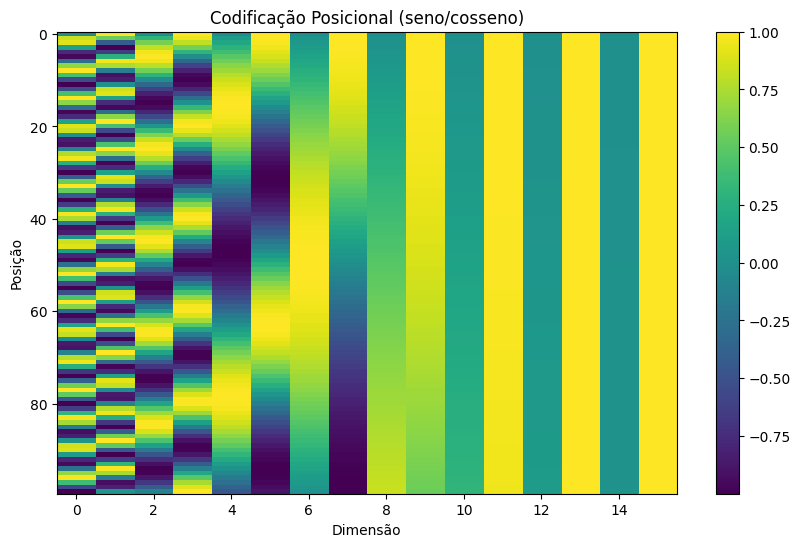

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(max_len, d_model):
    PE = np.zeros((max_len, d_model))
    for pos in range(max_len):
        for i in range(0, d_model, 2):
            PE[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
            if i + 1 < d_model:
                PE[pos, i+1] = np.cos(pos / (10000 ** (i / d_model)))
    return PE

PE = positional_encoding(100, 16)  # 100 posições, 16 dimensões

plt.figure(figsize=(10, 6))
plt.imshow(PE, cmap="viridis", aspect="auto")
plt.colorbar()
plt.title("Codificação Posicional (seno/cosseno)")
plt.xlabel("Dimensão")
plt.ylabel("Posição")
plt.show()

## Como interpretar o Positional Encoding

No gráfico do *positional encoding* (seno/cosseno):

- **Eixo vertical (posição):** representa cada token na sequência (posição 0, 1, 2, ...).  
- **Eixo horizontal (dimensão):** representa as diferentes dimensões do vetor de posição.  
- **Cores:** cada cor mostra o valor da função seno/cosseno naquela posição e dimensão.

### Intuições importantes
- As **primeiras dimensões** variam lentamente → capturam relações de **longo alcance**.  
- As **dimensões mais altas** variam rapidamente → capturam relações de **curto alcance**.  
- Como cada dimensão tem uma frequência diferente, combinando todas elas o modelo consegue distinguir a posição de qualquer token.  
- Além disso, a natureza periódica (seno/cosseno) permite que o modelo **extrapole posições** que não viu durante o treino.

Em resumo: cada linha do heatmap é um "vetor de posição", e as variações de frequência ao longo das dimensões dão ao Transformer a capacidade de reconhecer **ordem** e **distância** entre tokens.

## Exemplo numérico de vetores de Positional Encoding

Além do heatmap, podemos olhar diretamente os **valores numéricos** de alguns vetores de posição.

- Cada posição é representada por um **vetor** de mesmo tamanho que os embeddings do modelo (ex.: 16, 32, 512 dimensões).
- Esse vetor combina senos e cossenos em frequências diferentes.
- Isso garante que **posições próximas** tenham vetores parecidos, mas **nunca idênticos**.

Abaixo, mostramos as primeiras 8 dimensões para as posições `0, 1, 2, 3`.

In [ ]:
import numpy as np
import pandas as pd

def positional_encoding(max_len, d_model):
    PE = np.zeros((max_len, d_model))
    for pos in range(max_len):
        for i in range(0, d_model, 2):
            PE[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
            if i + 1 < d_model:
                PE[pos, i+1] = np.cos(pos / (10000 ** (i / d_model)))
    return PE

# Gerar PE com 16 dimensões
PE = positional_encoding(10, 16)

# Mostrar apenas as primeiras 8 dimensões para posições 0–3
df = pd.DataFrame(PE[:4, :8], index=[f"pos={i}" for i in range(4)])
df.round(4)

,0,1,2,3,4,5,6,7
pos=0,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000
pos=1,0.8415,0.5403,0.3110,0.9504,0.0998,0.9950,0.0316,0.9995
pos=2,0.9093,-0.4161,0.5911,0.8066,0.1987,0.9801,0.0632,0.9980
pos=3,0.1411,-0.9900,0.8126,0.5828,0.2955,0.9553,0.0947,0.9955


### Como ler a tabela

- Cada linha = uma **posição** na sequência.
- Cada coluna = uma **dimensão** do vetor posicional.
- Observe que:
  - Para `pos=0`, temos `[0, 1, 0, 1, ...]` (seno=0, cosseno=1).
  - À medida que `pos` aumenta, os valores mudam suavemente.
  - Diferentes dimensões variam em **ritmos distintos**: algumas mudam devagar (capturam longo alcance), outras mudam rápido (curto alcance).

Isso ajuda o Transformer a **diferenciar posições** e a codificar noções de ordem.